In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install transformers datasets torch torchvision

In [12]:
!pip install einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 682.5 kB/s eta 0:00:000:00:01


In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from einops import rearrange
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm



In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa giá trị pixel
])

# Load dữ liệu Fashion-MNIST
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)


100%|██████████| 26421880/26421880 [00:01<00:00, 18581863.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272752.85it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 925890.67it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12921769.59it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask=None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=1):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        return self.mlp_head(x[:, 0])


In [9]:
def train_epoch(model, optimizer, data_loader, loss_history):
    model.train()
    total_samples = len(data_loader.dataset)

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'[{batch_idx * len(data)}/{total_samples}] Loss: {loss.item():.4f}')
            loss_history.append(loss.item())

def evaluate(model, data_loader, loss_history):
    model.eval()
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = F.cross_entropy(output, target)
            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_samples += predicted.eq(target).sum()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct_samples / total_samples
    print(f'Average loss: {avg_loss:.4f}, Accuracy: {correct_samples}/{total_samples} ({accuracy:.2f}%)')
    loss_history.append(avg_loss)


In [14]:
# Khởi tạo mô hình, optimizer và scheduler
model = ViT(image_size=28, patch_size=7, num_classes=10, dim=64, depth=6, heads=8, mlp_dim=128).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train_loss_history = []
test_loss_history = []

N_EPOCHS = 10

for epoch in range(1, N_EPOCHS + 1):
    print(f'Epoch {epoch}/{N_EPOCHS}')
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)


Epoch 1/10
[0/60000] Loss: 2.3332
[6400/60000] Loss: 1.1106
[12800/60000] Loss: 1.1241
[19200/60000] Loss: 0.8937
[25600/60000] Loss: 0.4814
[32000/60000] Loss: 0.6084
[38400/60000] Loss: 0.5674
[44800/60000] Loss: 0.5884
[51200/60000] Loss: 0.4681
[57600/60000] Loss: 0.5239
Average loss: 0.4850, Accuracy: 8267/10000 (82.67%)
Epoch 2/10
[0/60000] Loss: 0.5261
[6400/60000] Loss: 0.5232
[12800/60000] Loss: 0.6132
[19200/60000] Loss: 0.4468
[25600/60000] Loss: 0.4057
[32000/60000] Loss: 0.2551
[38400/60000] Loss: 0.2990
[44800/60000] Loss: 0.4212
[51200/60000] Loss: 0.4791
[57600/60000] Loss: 0.4217
Average loss: 0.4108, Accuracy: 8492/10000 (84.92%)
Epoch 3/10
[0/60000] Loss: 0.4877
[6400/60000] Loss: 0.5555
[12800/60000] Loss: 0.3490
[19200/60000] Loss: 0.4039
[25600/60000] Loss: 0.5723
[32000/60000] Loss: 0.2976
[38400/60000] Loss: 0.4008
[44800/60000] Loss: 0.5303
[51200/60000] Loss: 0.3339
[57600/60000] Loss: 0.4540
Average loss: 0.3873, Accuracy: 8588/10000 (85.88%)
Epoch 4/10
[0/60

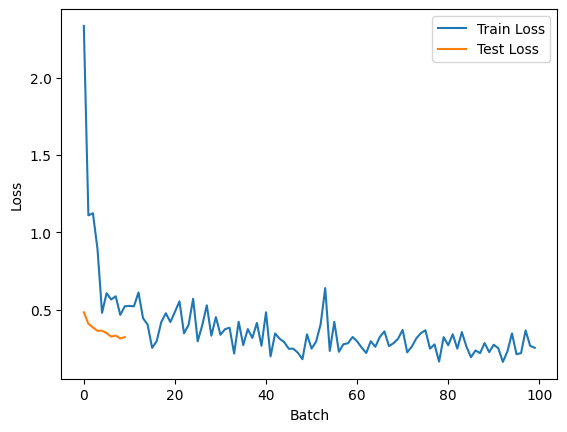

In [15]:
# Vẽ biểu đồ loss
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

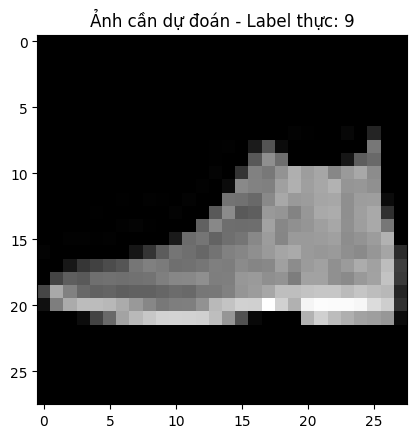

Label thực: 9, Dự đoán: 9


In [21]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for data, target in test_loader:  # test_loader -> testloader nếu testloader được định nghĩa từ trước
        data, target = data.to(DEVICE), target.to(DEVICE)  # DEVICE -> device nếu đã định nghĩa trước đó
        
        # Hiển thị ảnh trước khi dự đoán
        plt.imshow(data[0].cpu().squeeze(), cmap='gray')  # Sử dụng data[0] để lấy một ảnh
        plt.title(f'Ảnh cần dự đoán - Label thực: {target[0].item()}')
        plt.show()
        
        # Thực hiện dự đoán
        output = model(data)
        _, predicted = torch.max(output, 1)
        
        # In nhãn thực tế và nhãn dự đoán
        print(f'Label thực: {target[0].item()}, Dự đoán: {predicted[0].item()}')
        break
